# Worldwide Earthquake Forecaster

This notebook includes:
* Exploratory data analysis of earthquake dataset
* Applying geo-based and rapid mapping techniques
* Applying feature engineering and aggregation techniques
* Fitting XG Boost model to predict likelihood of earthquakes at future dates

In [ ]:
import numpy as np  
import pandas as pd  
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
import os
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv')

In [3]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-02-26T22:14:02.200Z,38.564167,-122.287666,2.860000,1.94,md,11.0,101.000000,0.028850,0.090000,...,2020-02-26T22:15:36.357Z,"14km E of Angwin, CA",earthquake,0.580000,1.350000,0.280,9.0,automatic,nc,nc
1,2020-02-26T22:12:06.275Z,34.994251,-97.812881,4.744703,1.99,ml,17.0,68.506142,0.061553,0.601049,...,2020-02-26T22:13:38.762Z,"11km ENE of Ninnekah, Oklahoma",earthquake,3.100692,2.402325,NaN,9.0,automatic,ok,ok
2,2020-02-26T21:58:21.440Z,35.893333,-117.731333,10.570000,0.70,ml,11.0,61.000000,0.085340,0.060000,...,2020-02-26T22:01:49.589Z,"16km ESE of Little Lake, CA",earthquake,0.180000,0.470000,0.165,6.0,automatic,ci,ci
3,2020-02-26T21:48:03.809Z,38.131500,-118.397600,4.000000,1.70,ml,8.0,88.320000,0.147000,0.172100,...,2020-02-26T22:12:15.816Z,"47km SSE of Hawthorne, Nevada",earthquake,NaN,6.600000,0.120,5.0,reviewed,nn,nn
4,2020-02-26T21:46:18.180Z,38.565166,-122.284332,3.160000,2.02,md,7.0,101.000000,0.026070,0.080000,...,2020-02-26T22:00:12.119Z,"14km E of Angwin, CA",earthquake,0.570000,1.150000,0.110,10.0,automatic,nc,nc


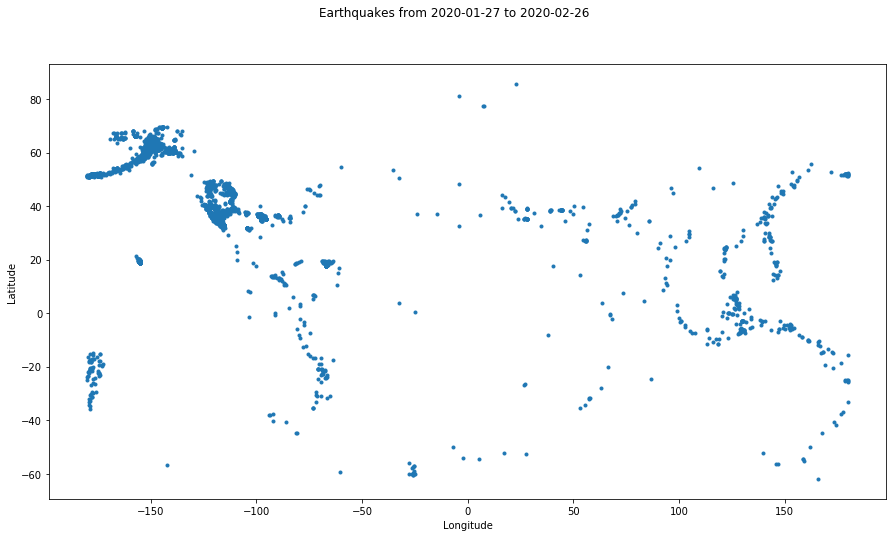

In [4]:
rounding_factor = 10
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(np.round(df['longitude'].head(10000),rounding_factor), 
         np.round(df['latitude'].head(10000),rounding_factor),
         linestyle='none', marker='.')
plt.suptitle('Earthquakes from ' + str(np.min(df['time']))[:10] + ' to ' + str(np.max(df['time']))[:10])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [5]:
df = df.sort_values('time', ascending=True)
df['date'] = df['time'].str[0:10]
# only keep the columns needed
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]
# df['date'] = df['time'].str.split(', ', expand=True) 
newdf = df['place'].str.split(', ', expand=True) 
df['place'] = newdf[1]
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]

print('total locations:',len(set(df['place'])))

# calculate mean lat lon for simplified locations
df_coords = df[['place', 'latitude', 'longitude']]
df_coords = df_coords.groupby(['place'], as_index=False).mean()
df_coords = df_coords[['place', 'latitude', 'longitude']]

df = df[['date', 'depth', 'mag', 'place']]
df = pd.merge(left=df, right=df_coords, how='inner', on=['place'])
df.head()

total locations: 111


,date,depth,mag,place,latitude,longitude
0,2020-01-27,9.19,1.71,CA,36.255844,-119.01318
1,2020-01-27,4.32,1.55,CA,36.255844,-119.01318
2,2020-01-27,4.28,1.41,CA,36.255844,-119.01318
3,2020-01-27,0.77,0.65,CA,36.255844,-119.01318
4,2020-01-27,8.66,0.94,CA,36.255844,-119.01318


In [6]:
print(set(df['place']))

{'Fiji', 'Romania', 'Puerto Rico', 'Papua New Guinea', 'South Korea', 'Nevada', 'Sakha', 'South Georgia and the South Sandwich Islands', 'India', 'Tajikistan', 'Wyoming', 'Dominica', 'Trinidad and Tobago', 'Azerbaijan', 'New Zealand', 'Morocco', 'Bosnia and Herzegovina', 'Bolivia', 'Guam', 'Iran', 'New Caledonia', 'Saudi Arabia', 'South Africa', 'Cayman Islands', 'Arkansas', 'Ecuador', 'Croatia', 'Washington', 'U.S. Virgin Islands', 'Tennessee', 'Alabama', 'CA', 'Mexico', 'South Sandwich Islands', 'Uganda', 'Idaho', 'Costa Rica', 'Wallis and Futuna', 'Texas', 'Panama', 'Australia', 'Peru', 'Burma', 'Colorado', 'Montana', 'Alaska', 'Japan region', 'Dominican Republic', 'Tanzania', 'Israel', 'Chile', 'Bangladesh', 'Pennsylvania', 'Svalbard and Jan Mayen', 'Greece', 'Georgia', 'NV', 'Missouri', 'Italy', 'Indonesia', 'North Carolina', 'East Timor', 'Tonga', 'California', 'Oregon', 'China', 'Pakistan', 'Jamaica', 'Canada', 'Kansas', 'B.C.', 'Argentina', 'Greenland', 'British Virgin Islands'

In [7]:
eq_tmp = df.copy()

DAYS_OUT_TO_PREDICT = 5

# loop through each zone and apply MA
eq_data = []
eq_data_last_days_out = []
for place in list(set(eq_tmp['place'])):
    temp_df = eq_tmp[eq_tmp['place'] == place].copy()
    temp_df['depth_avg_20'] = temp_df['depth'].rolling(window=20,center=False).mean() 
    temp_df['depth_avg_10'] = temp_df['depth'].rolling(window=10,center=False).mean()
    temp_df['depth_avg_5'] = temp_df['depth'].rolling(window=5,center=False).mean()
    temp_df['mag_avg_20'] = temp_df['mag'].rolling(window=20,center=False).mean() 
    temp_df['mag_avg_10'] = temp_df['mag'].rolling(window=10,center=False).mean()
    temp_df['mag_avg_5'] = temp_df['mag'].rolling(window=5,center=False).mean()
    temp_df.loc[:, 'mag_outcome'] = temp_df.loc[:, 'mag_avg_5'].shift(DAYS_OUT_TO_PREDICT * -1)

    eq_data_last_days_out.append(temp_df.tail(DAYS_OUT_TO_PREDICT))

    eq_data.append(temp_df)

# concat all location-based dataframes into master dataframe
import pandas as pd
eq_all = pd.concat(eq_data)

# remove any NaN fields
eq_all = eq_all[np.isfinite(eq_all['depth_avg_20'])]
eq_all = eq_all[np.isfinite(eq_all['mag_avg_20'])]
eq_all = eq_all[np.isfinite(eq_all['mag_outcome'])]

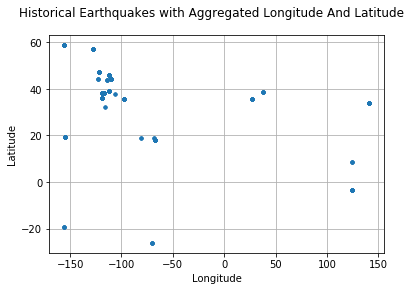

In [8]:
plt.plot(eq_all['longitude'], 
         eq_all['latitude'],
         linestyle='none', marker='.')
plt.suptitle('Historical Earthquakes with Aggregated Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [9]:
# keep our live data for predictions
eq_data_last_days_out = pd.concat(eq_data_last_days_out)
eq_data_last_days_out = eq_data_last_days_out[np.isfinite(eq_data_last_days_out['mag_avg_20'])]

In [10]:
eq_all['mag_outcome'] = np.where(eq_all['mag_outcome'] > 2.5, 1,0)
print(eq_all['mag_outcome'].describe())

count    10289.000000
mean         0.112061
std          0.315457
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: mag_outcome, dtype: float64


In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
features = [f for f in list(eq_all) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

X_train, X_test, y_train, y_test = train_test_split(eq_all[features],
                     eq_all['mag_outcome'], test_size=0.3, random_state=42)
  
dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 3,  # the maximum depth of each tree
        'eta': 0.1,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset

num_round = 500  # the number of training iterations    
early_stopping_rounds=30
bst = xgb.train(param, dtrain, num_round) #, early_stopping_rounds=early_stopping_rounds)
 
preds = bst.predict(dtest)
np.mean(preds)
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc

#print (auc(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,2))

AUC: 0.99


In [12]:
def get_xgb_imp(xgb, feat_names):
    imp_vals = xgb.get_fscore()
    feats_imp = pd.DataFrame(imp_vals,index=np.arange(2)).T
    feats_imp.iloc[:,0]= feats_imp.index    
    feats_imp.columns=['feature','importance']
    feats_imp.sort_values('importance',inplace=True,ascending=False)
    feats_imp.reset_index(drop=True,inplace=True)
    return feats_imp

feature_importance_df = get_xgb_imp(bst, features)
feature_importance_df

,feature,importance
0,mag_avg_20,621
1,depth_avg_20,456
2,mag_avg_5,449
3,depth_avg_10,406
4,mag_avg_10,402
5,depth_avg_5,362
6,depth,181


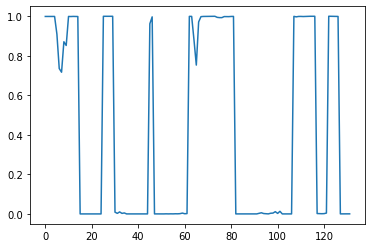

In [13]:
# train on live data
dlive = xgb.DMatrix(eq_data_last_days_out[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

In [14]:
live_set = eq_data_last_days_out[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(DAYS_OUT_TO_PREDICT,unit='d')

live_set.head()

,date,place,latitude,longitude,quake
0,2020-02-06,Cayman Islands,18.924696,-80.774764,0.999629
1,2020-02-07,Cayman Islands,18.924696,-80.774764,0.999629
2,2020-02-12,Greece,35.755330,26.602851,0.999519
3,2020-02-14,Dominican Republic,19.051193,-68.028846,0.999214
4,2020-02-15,Greece,35.755330,26.602851,0.999649


In [15]:
# see how our map will look using probability intensities
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()
days

predict_day = days[1]

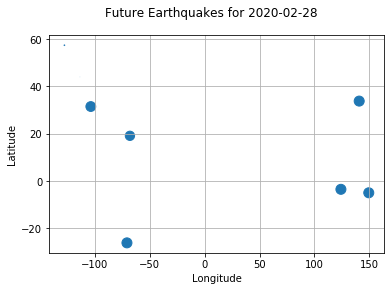

In [16]:
live_set_tmp = live_set[live_set['date'] == predict_day]
plt.scatter(live_set_tmp['longitude'], 
         live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
plt.suptitle('Future Earthquakes for ' + predict_day)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [17]:
import xgboost as xgb
    
def prepare_earthquake_data_and_model(days_out_to_predict = 5, max_depth=3, eta=0.1):
    import pandas as pd
    import numpy as np
    # get latest data from USGS servers
    df = pd.read_csv('https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv')
    df = df.sort_values('time', ascending=True)
    # truncate time from datetime
    df['date'] = df['time'].str[0:10]
    
    # only keep the columns needed
    df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]
    temp_df = df['place'].str.split(', ', expand=True) 
    df['place'] = temp_df[1]
    df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]

    # calculate mean lat lon for simplified locations
    df_coords = df[['place', 'latitude', 'longitude']]
    df_coords = df_coords.groupby(['place'], as_index=False).mean()
    df_coords = df_coords[['place', 'latitude', 'longitude']]

    df = df[['date', 'depth', 'mag', 'place']]
    df = pd.merge(left=df, right=df_coords, how='inner', on=['place'])
    
    # loop through each zone and apply MA
    eq_data = []
    df_live = []
    for symbol in list(set(df['place'])):
        temp_df = df[df['place'] == symbol].copy()
        temp_df['depth_avg_20'] = temp_df['depth'].rolling(window=20,center=False).mean() 
        temp_df['depth_avg_10'] = temp_df['depth'].rolling(window=10,center=False).mean()
        temp_df['depth_avg_5'] = temp_df['depth'].rolling(window=5,center=False).mean()
        temp_df['mag_avg_20'] = temp_df['mag'].rolling(window=20,center=False).mean() 
        temp_df['mag_avg_10'] = temp_df['mag'].rolling(window=10,center=False).mean()
        temp_df['mag_avg_5'] = temp_df['mag'].rolling(window=5,center=False).mean()
        temp_df.loc[:, 'mag_outcome'] = temp_df.loc[:, 'mag_avg_5'].shift(days_out_to_predict * -1)

        df_live.append(temp_df.tail(days_out_to_predict))

        eq_data.append(temp_df)

    # concat all location-based dataframes into master dataframe
    df = pd.concat(eq_data)

    # remove any NaN fields
    df = df[np.isfinite(df['depth_avg_20'])]
    df = df[np.isfinite(df['mag_avg_20'])]
    df = df[np.isfinite(df['mag_outcome'])]

    # prepare outcome variable
    df['mag_outcome'] = np.where(df['mag_outcome'] > 2.5, 1,0)
 
    df = df[['date',
             'latitude',
             'longitude',
             'depth_avg_20',
             'depth_avg_10',
             'depth_avg_5',
             'mag_avg_20', 
             'mag_avg_10',
             'mag_avg_5',
             'mag_outcome']]

    # keep only data where we can make predictions
    df_live = pd.concat(df_live)
    df_live = df_live[np.isfinite(df_live['mag_avg_20'])]
    
    # let's train the model whenever the webserver is restarted
    from sklearn.model_selection import train_test_split
    features = [f for f in list(df) if f not in ['date', 'mag_outcome', 'latitude',
     'longitude']]

    X_train, X_test, y_train, y_test = train_test_split(df[features],
                         df['mag_outcome'], test_size=0.3, random_state=42)

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)

    param = {
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'eval_metric': 'auc',
            'max_depth': max_depth,  # the maximum depth of each tree
            'eta': eta,  # the training step for each iteration
            'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset

    num_round = 500  # the number of training iterations    
    early_stopping_rounds=30
    xgb_model = xgb.train(param, dtrain, num_round) 
    

    # train on live data
    dlive = xgb.DMatrix(df_live[features])  
    preds = xgb_model.predict(dlive)

    # add preds to live data
    df_live = df_live[['date', 'place', 'latitude', 'longitude']]
    
    # add predictions back to dataset 
    df_live = df_live.assign(preds=pd.Series(preds).values)

    # aggregate down dups
    df_live = df_live.groupby(['date', 'place'], as_index=False).mean()
 
    # increment date to include DAYS_OUT_TO_PREDICT
    df_live['date']= pd.to_datetime(df_live['date'],format='%Y-%m-%d') 
    df_live['date'] = df_live['date'] + pd.to_timedelta(days_out_to_predict,unit='d')

    return(df_live)

df_live = prepare_earthquake_data_and_model()
df_live.tail()

,date,place,latitude,longitude,preds
66,2020-03-02,Puerto Rico,17.995972,-66.914092,0.834540
67,2020-03-02,Texas,31.421990,-103.663905,0.996118
68,2020-03-02,Utah,39.154341,-112.288092,0.000018
69,2020-03-02,Washington,47.124280,-121.790372,0.002556
70,2020-03-02,Wyoming,44.331416,-110.647182,0.000006


In [20]:
from datetime import datetime
datetime_object = datetime.strptime("02/27/2020", '%m/%d/%Y')
list(set([d for d in df_live['date'] if d == datetime_object]))

[Timestamp('2020-02-27 00:00:00')]

In [21]:
def get_earth_quake_estimates(desired_date, df_live):
    from datetime import datetime
    datetime_object = desired_date #datetime.strptime(desired_date, '%m/%d/%Y')
    live_set_tmp = df_live[df_live['date'] == datetime_object]
    
    # format lat/lons like Google Maps expects
    LatLngString = ''
    if (len(live_set_tmp) > 0):
        for lat, lon, pred in zip(live_set_tmp['latitude'], live_set_tmp['longitude'], live_set_tmp['preds']): 
            # this is the threshold of probability to decide what to show and what not to show
            if (pred > 0.3):
                LatLngString += "new google.maps.LatLng(" + str(lat) + "," + str(lon) + "),"
        
    return(LatLngString)
 
get_earth_quake_estimates(datetime.strptime("02/29/2020", '%m/%d/%Y'), df_live)

'new google.maps.LatLng(-26.180206249999998,-70.75349062499998),new google.maps.LatLng(-3.554552688172042,124.11368494623656),new google.maps.LatLng(33.721791836734695,140.76126530612245),new google.maps.LatLng(38.59848787878788,37.96097575757576),'

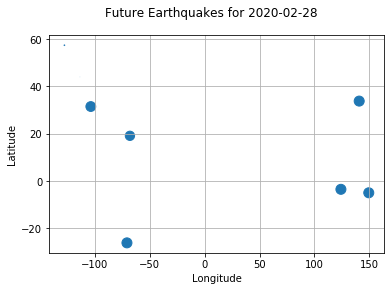

In [22]:
# train on live data
dlive = xgb.DMatrix(eq_data_last_days_out[features]) #, label=[])

preds = bst.predict(dlive)
# see how our map will look using probability intensities
days = list(set([d for d in live_set['date'].astype(str) if d > dt.datetime.today().strftime('%Y-%m-%d')]))
days.sort()
predict_day = days[1]


live_set_tmp = live_set[live_set['date'] == predict_day]
plt.scatter(live_set_tmp['longitude'], 
         live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
plt.suptitle('Future Earthquakes for ' + predict_day)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()